## Time Series Forecasting
### Data Loading

In [1]:
import pandas as pd 

dataset = pd.read_csv("AirPassengers.csv")

In [2]:
#take a look at the original dataset
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
#Set datatime as dataframe index
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Data Plot

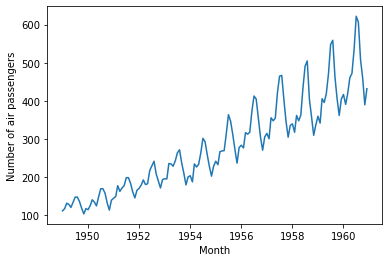

In [5]:
import matplotlib.pylab as plt
%matplotlib inline 

## plot graph
plt.plot(indexedDataset)
plt.xlabel('Month')
plt.ylabel('Number of air passengers')
plt.show()

A stationary Time Series is one which characteristics like mean and variance does not change over time.

However, real world data are often non-stationary or have means, variances, and covariances that change over time. Non-stationary behaviors can be trends, cycles, random walks, or combinations of the three.

Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted. The results obtained by using non-stationary time series may be spurious in that they may indicate a relationship between two variables where one does not exist. In order to receive consistent, reliable results, the non-stationary data needs to be transformed into stationary data.

So here. we need to preparing our data for analyzing the Rolling Mean and Standard Deviation to check stationarity for given Time Series.

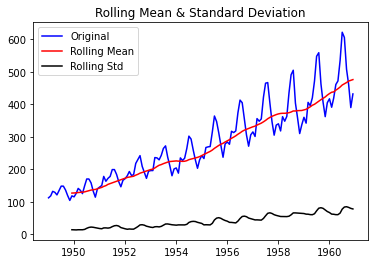

In [6]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()

#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

By looking the plot, we conclude that, it is non-stationary because its mean and variance are not constant.

### Data Transformation to achieve Stationarity 
There are a couple of ways to achieve stationarity through data transformation like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on ...

In our example, let's start with log transformations. Our objective is to remove the trend component. Hence, if we can achieve flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log, we would say that our data transformation did a good job.

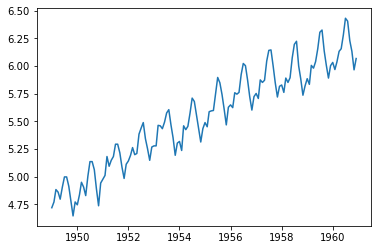

In [9]:
import numpy as np

#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)
plt.show()

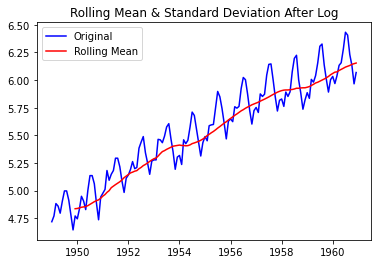

In [13]:
#Determine rolling statistics
movingAverage = indexedDataset_logScale.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
movingSTD = indexedDataset_logScale.rolling(window=12).std()

#Plot rolling statistics
orig = plt.plot(indexedDataset_logScale, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
# std = plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation After Log')
plt.show()

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can at least say that we are heading in the right direction.

Now, let's try out the simple time shift technique, which is simply: all x shifted by 1 position to right, so that you will get null,(x1−x0),(x2−x1),(x3−x2),(x4−x3),....(xn−xn−1).

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
1949-07-01,0.091937
1949-08-01,0.000000
1949-09-01,-0.084557
1949-10-01,-0.133531


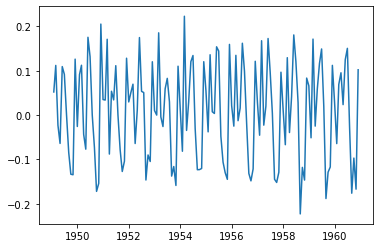

In [21]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

#Remove NAN values
datasetLogDiffShifting.dropna(inplace=True)
datasetLogDiffShifting.head(10)

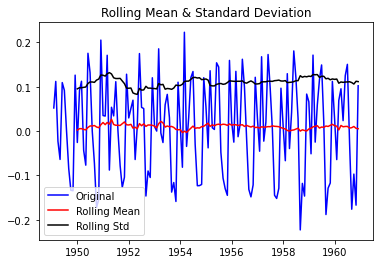

In [22]:
#Determine rolling statistics
movingAverage = datasetLogDiffShifting.rolling(window=12).mean()
movingSTD = datasetLogDiffShifting.rolling(window=12).std()

#Plot rolling statistics
orig = plt.plot(datasetLogDiffShifting, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

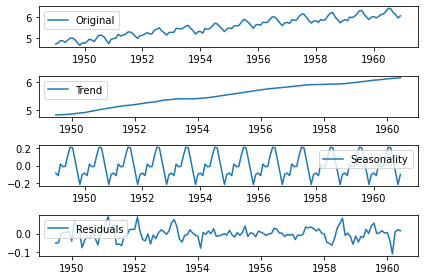

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

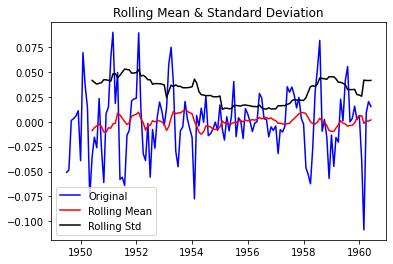

In [19]:
#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

#Determine rolling statistics
movingAverage = decomposedLogData.rolling(window=12).mean()
movingSTD =decomposedLogData.rolling(window=12).std()

#Plot rolling statistics
orig = plt.plot(decomposedLogData, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Plotting ACF & PACF

C:\ProgramData\Anaconda3\envs\py37tf\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


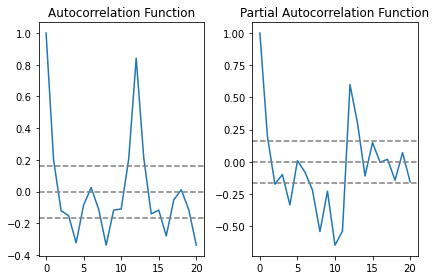

In [23]:
#ACF & PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()   

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

### Building Models

C:\ProgramData\Anaconda3\envs\py37tf\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\envs\py37tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so 

Plotting ARIMA model


C:\ProgramData\Anaconda3\envs\py37tf\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


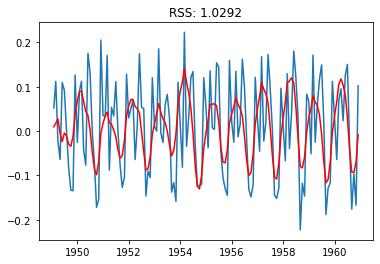

In [24]:
#Building the ARIMA model with p=2, q=2 and I=1
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

### Prediction & Reverse transformations

In [25]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [26]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372554
1960-09-01    1.280204
1960-10-01    1.186191
1960-11-01    1.116267
1960-12-01    1.108140
Length: 143, dtype: float64


In [27]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

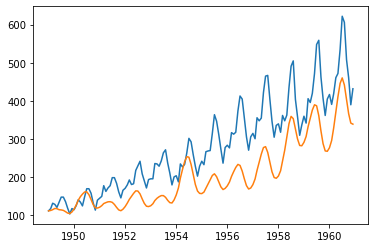

In [28]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)